Import Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
import os

Load the Model and Vectorizer

In [35]:
model = joblib.load("/content/xgb_fake_job_model.pkl")
vectorizer = joblib.load("/content/tfidf_vectorizer.pkl")

Create SHAP explainer and local prediction explanation

In [36]:
import shap
shap.initjs()

# example job description to analyze (customizable)
example_text = ["Earn $1000/week from home. Apply now!"]

# vectorize the input
example_vec = vectorizer.transform(example_text)

# create SHAP explainer
explainer = shap.Explainer(model)

# calculate SHAP values
shap_values = explainer(example_vec)

from IPython.display import display

# Show SHAP force plot (interactive JS-based plot)
display(shap.force_plot(
    explainer.expected_value,
    shap_values.values[0],
    feature_names=vectorizer.get_feature_names_out()
))


Waterfall plot

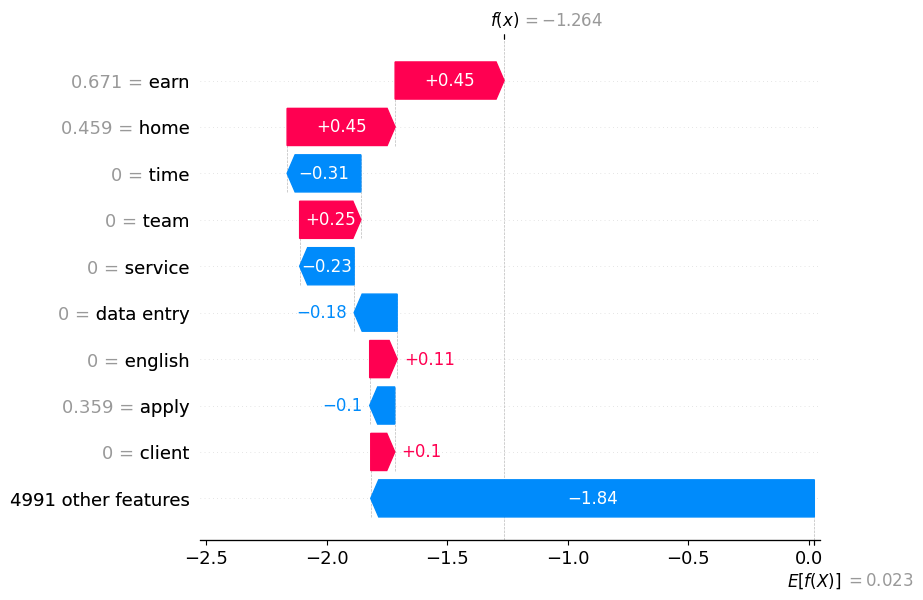

In [37]:
# get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# assign them to the SHAP Explanation object
shap_values.feature_names = feature_names.tolist()

# plot with actual token names
shap.plots.waterfall(shap_values[0])

Load Data and Preprocess Again

In [38]:
df = pd.read_csv("/content/fake_job_postings.csv")
df.head()
# Apply same cleaning pipeline
df['clean_text'] = df['description'].fillna("").str.lower()
df['clean_text'] = df['clean_text'].str.replace(r'[^\w\s]', '', regex=True)

# Extract labels
Y = df['fraudulent']

# vectorize Text with Loaded Vectorizer
X = vectorizer.transform(df['clean_text'])

Split Data and Predict Again

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42
)

Y_pred = model.predict(X_test)

Classification Report & Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       0.87      0.28      0.42       173

    accuracy                           0.96      3576
   macro avg       0.92      0.64      0.70      3576
weighted avg       0.96      0.96      0.95      3576



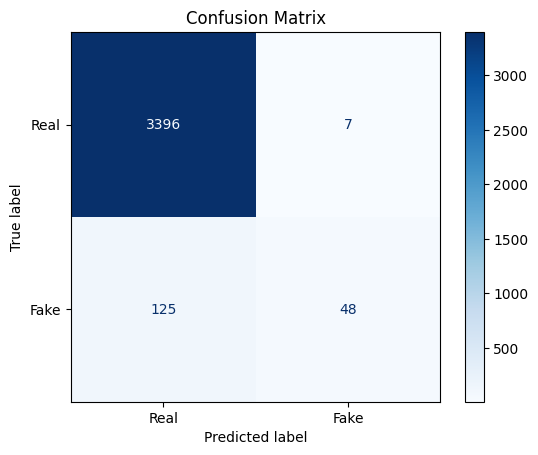

In [40]:
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Top Predictive Words (Feature Importance)

In [41]:
features = vectorizer.get_feature_names_out()
importances = model.feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]

print("Top 20 Predictive Words for Fake/Real Jobs:\n")
for idx in top_idx:
    print(f"{features[idx]} → importance: {importances[idx]:.4f}")

Top 20 Predictive Words for Fake/Real Jobs:

oil → importance: 0.0384
home → importance: 0.0310
data entry → importance: 0.0305
income → importance: 0.0223
free → importance: 0.0208
within → importance: 0.0206
cash → importance: 0.0205
responsibility include → importance: 0.0188
duty → importance: 0.0152
work home → importance: 0.0143
integral → importance: 0.0116
sponsored → importance: 0.0105
worklife → importance: 0.0103
facility → importance: 0.0101
computer → importance: 0.0097
integral part → importance: 0.0095
passionate → importance: 0.0091
wage → importance: 0.0091
time → importance: 0.0084
apply → importance: 0.0079


Saving Report

<Figure size 640x480 with 0 Axes>

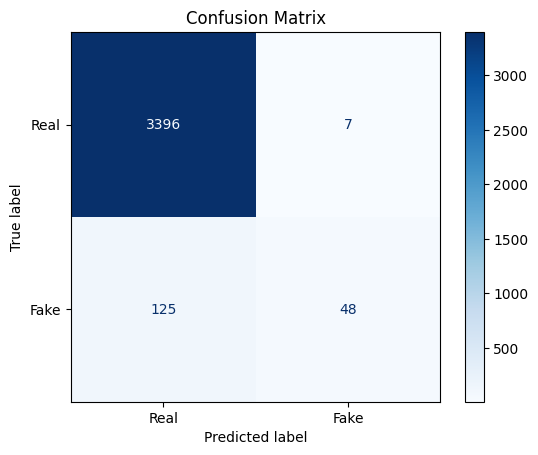

In [42]:
# Classification Report as CSV or TXT (optional)
report = classification_report(Y_test, Y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv("classification_report.csv")

# Save confusion matrix plot
plt.figure()
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("results.png")